In [73]:
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
import glob

In [74]:
def get_center(inputfilename):
    file = fits.open(inputfilename)
    #WCS info from header
    CRVAL1 = file[1].header['CRVAL1']
    CRVAL2 = file[1].header['CRVAL2']
    CRPIX1 = file[1].header['CRPIX1']
    CRPIX2 = file[1].header['CRPIX2']
    CD1_1 = file[1].header['CD1_1']
    CD1_2 = file[1].header['CD1_2']
    CD2_1 = file[1].header['CD2_1']
    CD2_2 = file[1].header['CD2_2']
    
    A = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
    A_inv = np.linalg.inv(A)
    B = np.array([[CRVAL1],[CRVAL2]])
    r0 = np.array([[CRPIX1],[CRPIX2]])
    
    def coo_pixtosky(r):
        return np.matmul(A, r-r0) + B
    
    def coo_skytopix(r_sky):
        return np.matmul(A_inv, r_sky - B) + r0
    
    #Target location info
    RA_TARG = file[0].header['RA_TARG'] 
    DEC_TARG = file[0].header['DEC_TARG']
    r_sky_TARG = np.array([[RA_TARG], [DEC_TARG]])
    X_TARG, Y_TARG = int(coo_skytopix(r_sky_TARG)[0]), int(coo_skytopix(r_sky_TARG)[1])
    
    data = file[1].data
    
    s = 100
    max_i = 0
    max_j = 0
    maxval = 0
    for i in range(Y_TARG-s, Y_TARG+s+1):
        for j in range(X_TARG-s, X_TARG+s+1):
            if data[i][j] > maxval:
                maxval = data[i][j]
                max_i = i
                max_j = j 
    r = 50
    total_flux = 0
    i_integral = 0
    j_integral = 0
    for i in range(max_i-r, max_i+r+1):
        for j in range(max_j-r, max_j+r+1):
            total_flux += data[i][j]
            i_integral += i*data[i][j]
            j_integral += j*data[i][j]
    
    i_center = i_integral/total_flux
    j_center = j_integral/total_flux
    
    X_center = j_center +1
    Y_center = i_center +1
    r_center = np.array([[X_center], [Y_center]])
    

    return int(X_center), int(Y_center)

In [84]:
path = '/Users/ha/Makani_Project/DrizzlePac'
lst_01 = glob.glob(path + "/F150LP/01/*.fits")
lst_03 = glob.glob(path + "/F150LP/03/*.fits")
lst_150 = glob.glob(path + "/F150LP/*/*.fits")
lst_165 = glob.glob(path + "/F165LP/*/*.fits")
lst_raw_57 = glob.glob(path + '/data/57/*/*raw.fits')
dark_lst = glob.glob(path + '/darks/HST/*/*raw.fits')

In [85]:
dark_lst

['/Users/ha/Makani_Project/DrizzlePac/darks/HST/j8et02u8q/j8et02u8q_raw.fits',
 '/Users/ha/Makani_Project/DrizzlePac/darks/HST/jb9q01aaq/jb9q01aaq_raw.fits',
 '/Users/ha/Makani_Project/DrizzlePac/darks/HST/j8hk01vnq/j8hk01vnq_raw.fits',
 '/Users/ha/Makani_Project/DrizzlePac/darks/HST/jelg01dsq/jelg01dsq_raw.fits',
 '/Users/ha/Makani_Project/DrizzlePac/darks/HST/jc5901muq/jc5901muq_raw.fits',
 '/Users/ha/Makani_Project/DrizzlePac/darks/HST/je5x01jwq/je5x01jwq_raw.fits',
 '/Users/ha/Makani_Project/DrizzlePac/darks/HST/jb9q02ejq/jb9q02ejq_raw.fits',
 '/Users/ha/Makani_Project/DrizzlePac/darks/HST/jefz02fkq/jefz02fkq_raw.fits',
 '/Users/ha/Makani_Project/DrizzlePac/darks/HST/jd4c01u0q/jd4c01u0q_raw.fits',
 '/Users/ha/Makani_Project/DrizzlePac/darks/HST/jefz02g2q/jefz02g2q_raw.fits',
 '/Users/ha/Makani_Project/DrizzlePac/darks/HST/j8et12lzq/j8et12lzq_raw.fits',
 '/Users/ha/Makani_Project/DrizzlePac/darks/HST/jb9q03e2q/jb9q03e2q_raw.fits',
 '/Users/ha/Makani_Project/DrizzlePac/darks/HST/j8et

In [77]:
temp = []
cps = []
max_dark = 0
maxdark_item = None

max_temp = 0
maxtemp_file = None

min_dark = 10000
mindark_item = None

min_temp = 10000
mintemp_item = None

for item in lst_150 + lst_165:
    file = fits.open(item)
    t = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2
    
    exp_t = file[0].header['EXPTIME']
    
    sample_data = file[1].data[255:767, 255: 767]
    s1 = sum(sum(sample_data))
    
    
    e = 30
    center = get_center(item)
    subtract_data = file[1].data[center[1] - e : center[1]+ e, center[0] - e: center[0] + e ]
    s2 = sum(sum(subtract_data))
    
    
    dark =((s1 - s2)/exp_t)/(len(sample_data[0])*len(sample_data) - len(subtract_data[0])*len(subtract_data))
    temp.append(t)
    cps.append(dark)
    
    if dark > max_dark:
        max_dark = dark
        maxdark_item = item
        
    if dark < min_dark:
        min_dark = dark
        mindark_item = item
        
    if t > max_temp:
        max_temp = t
        maxtemp_item = item
    
    if t < min_temp:
        min_temp = t
        mintemp_item = item

print('maxdark:', maxdark_item, max_dark)
print('mindark:', mindark_item, min_dark)
print('maxtemp:', maxtemp_item, max_temp)
print('mintemp:', mintemp_item, min_temp)
print()
#plt.plot(temp, cps,'o')

maxdark: /Users/ha/Makani_Project/DrizzlePac/F165LP/09/hst_16231_09_acs_sbc_f165lp_jec409ie_flt.fits 0.00012262444245733626
mindark: /Users/ha/Makani_Project/DrizzlePac/F165LP/04/hst_16231_04_acs_sbc_f165lp_jec404gr_flt.fits 1.0381551471910347e-05
maxtemp: /Users/ha/Makani_Project/DrizzlePac/F165LP/09/hst_16231_09_acs_sbc_f165lp_jec409ie_flt.fits 28.5594
mintemp: /Users/ha/Makani_Project/DrizzlePac/F165LP/08/hst_16231_08_acs_sbc_f165lp_jec408h4_flt.fits 17.8146



In [86]:
dark_lst = glob.glob(path + '/darks/HST/*/*raw.fits')
w_data = np.zeros((1024,1024))
total_time = 0
uptemp = 25.0
lowtemp = 0.0
for item in dark_lst:
    file = fits.open(item)
    
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    year = int(file[0].header['DATE'][:4])
    data = file[1].data
    
    if temp <= uptemp and year > 2010 and year != 2019 and year != 2020:
        w_data += data
        total_time += exptime
    
w_data_cps = w_data / total_time
print(w_data_cps)
avg_dark_Primary = fits.PrimaryHDU(w_data_cps)
avg_dark_hdul = fits.HDUList([avg_dark_Primary])
avg_dark_hdul.writeto('avg_dark_uptemp25.fits', overwrite = True)

[[5.89553843e-04 4.69800719e-04 1.44317868e-04 ... 3.96106488e-04
  4.29883010e-05 5.22000798e-05]
 [4.85153683e-04 1.87306169e-04 6.44824516e-05 ... 6.44824516e-05
  4.60588940e-05 3.37765222e-05]
 [1.53529647e-05 6.14118586e-05 5.22000798e-05 ... 3.07059293e-05
  3.99177081e-05 1.84235576e-05]
 ...
 [7.67648233e-05 7.06236374e-05 3.99177081e-05 ... 6.14118586e-06
  6.14118586e-06 1.22823717e-05]
 [8.90471950e-05 1.10541346e-04 1.04400160e-04 ... 6.14118586e-06
  4.29883010e-05 5.83412657e-05]
 [1.75944975e-03 3.50047594e-04 5.31212577e-04 ... 3.07059293e-06
  1.84235576e-05 2.76353364e-05]]


In [102]:
w_data = np.zeros((1024,1024))
total_time = 0
uptemp = 25.0
lowtemp = 0.0
for item in dark_lst:
    file = fits.open(item)
    
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    year = int(file[0].header['DATE'][:4])
    data = file[1].data
    
    #if temp <= uptemp and year > 2010 and year != 2019 and year != 2020:
    #    w_data += data
    #    total_time += exptime
    
    if temp <= 22.0 and year == 2022:
        w_data += data
        total_time += exptime
    
w_data_cps = w_data / total_time
    
avg_dark_Primary = fits.PrimaryHDU(w_data_cps)
avg_dark_hdul = fits.HDUList([avg_dark_Primary])
avg_dark_hdul.writeto('avg_dark_uptemp22.fits', overwrite = True)

In [103]:
w_data = np.zeros((1024,1024))
total_time = 0
uptemp = 25.0
lowtemp = 0.0
for item in dark_lst:
    file = fits.open(item)
    
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    year = int(file[0].header['DATE'][:4])
    data = file[1].data
    
    if temp <= uptemp and year == 2022:
        w_data += data
        total_time += exptime
    
    
w_data_cps = w_data / total_time
    
avg_dark_Primary = fits.PrimaryHDU(w_data_cps)
avg_dark_hdul = fits.HDUList([avg_dark_Primary])
avg_dark_hdul.writeto('avg_dark_uptemp25.fits', overwrite = True)

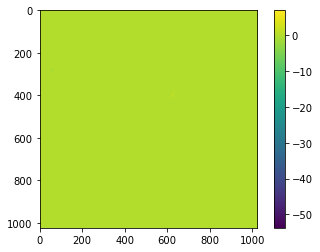

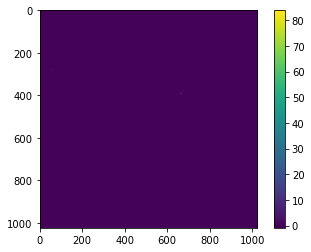

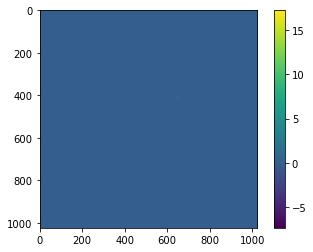

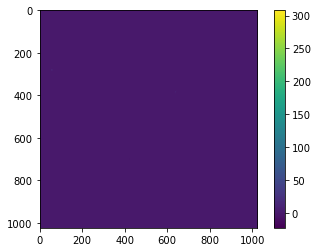

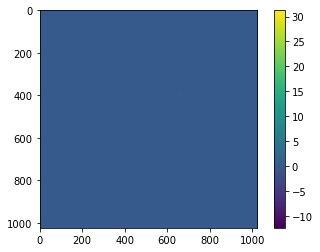

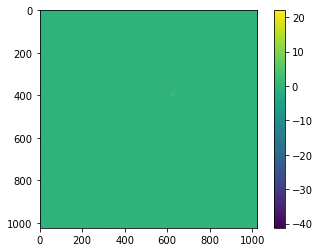

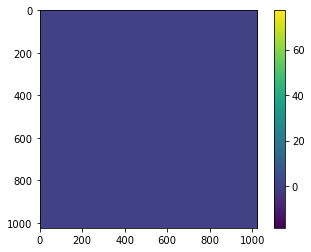

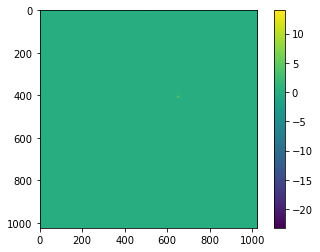

In [104]:
dark_file = fits.open('avg_dark_uptemp22.fits')
for filename in lst_raw_57:
    file = fits.open(filename)
    data = file[1].data
    exptime = file[0].header['EXPTIME']
    dark_frame = dark_file[0].data * exptime
    #print((file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2)
    new_data = data - dark_frame
    plt.imshow(new_data)
    plt.colorbar()
    plt.show()
    Primary = fits.PrimaryHDU(data)
    hdul = fits.HDUList([Primary])
    hdul.writeto(filename[-17:-9] + '_original.fits', overwrite = True)
    
    subtracted_Primary = fits.PrimaryHDU(new_data)
    subtracted_hdul = fits.HDUList([subtracted_Primary])
    subtracted_hdul.writeto(filename[-17:-9] + '_subtracted_22.fits', overwrite = True)

25.629


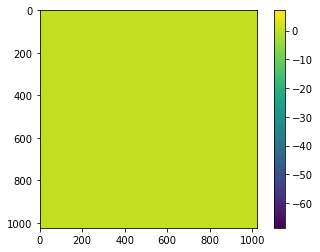

19.8903


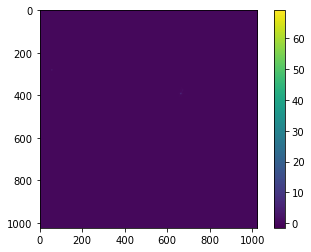

25.262700000000002


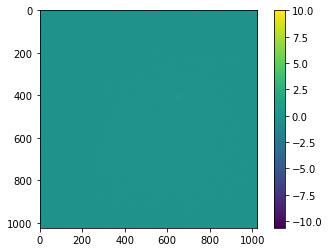

18.791400000000003


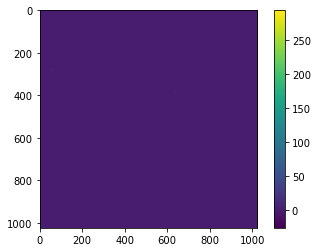

24.8964


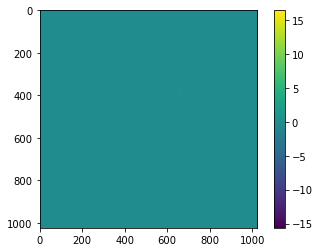

21.477600000000002


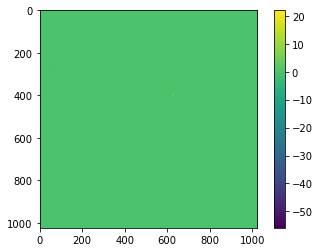

24.5301


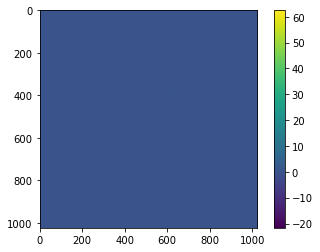

20.744999999999997


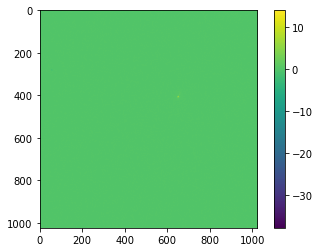

In [105]:
dark_file = fits.open('avg_dark_uptemp25.fits')
for filename in lst_raw_57:
    file = fits.open(filename)
    data = file[1].data
    exptime = file[0].header['EXPTIME']
    dark_frame = dark_file[0].data * exptime
    print((file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2)
    new_data = data - dark_frame
    plt.imshow(new_data)
    plt.colorbar()
    plt.show()
    Primary = fits.PrimaryHDU(data)
    hdul = fits.HDUList([Primary])
    hdul.writeto(filename[-17:-9] + '_original.fits', overwrite = True)
    
    subtracted_Primary = fits.PrimaryHDU(new_data)
    subtracted_hdul = fits.HDUList([subtracted_Primary])
    subtracted_hdul.writeto(filename[-17:-9] + '_subtracted_25.fits', overwrite = True)